In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [5]:
df = pd.read_csv('..\datasets\salary_data_cleaned.csv')
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\r\n,NM,0,49,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\r\n,MD,0,38,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\r\n,FL,1,12,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\r\n,WA,1,57,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\r\n,NY,1,24,1,0,0,0,1


In [6]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel'],
      dtype='object')

## Feature Engineering

In [7]:
def title_simplifier(title):
    '''
    Remove unwanted words from job title
    '''
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na' # not specified

df['job_simp'] = df['Job Title'].apply(title_simplifier)
df.job_simp.value_counts()

data scientist    279
na                184
data engineer     119
analyst           102
manager            22
mle                22
director           14
Name: job_simp, dtype: int64

In [8]:
def seniority(title):
    '''
    Detect the seniority level from job title
    '''
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
        return 'jr'
    else:
        return 'na'

df['seniority'] = df['Job Title'].apply(seniority)
df.seniority.value_counts()

na        519
senior    220
jr          3
Name: seniority, dtype: int64

In [9]:
# Fix state Los Angeles 
df['job_state'] = df.job_state.apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')
df.job_state.value_counts()

CA    152
MA    103
NY     72
VA     41
IL     40
MD     35
PA     33
TX     28
NC     21
WA     21
NJ     17
FL     16
OH     14
TN     13
DC     11
CO     11
WI     10
UT     10
IN     10
AZ      9
MO      9
AL      8
GA      6
DE      6
KY      6
MI      6
CT      5
IA      5
LA      4
OR      4
NE      4
NM      3
KS      3
ID      2
MN      2
RI      1
SC      1
Name: job_state, dtype: int64

In [10]:
# Job description length 
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))
df['desc_len']

0      2555
1      4828
2      3495
3      3926
4      2748
       ... 
737    6219
738    6167
739    3107
740    1678
741    3710
Name: desc_len, Length: 742, dtype: int64

In [11]:
# Competitor count
df['num_comp'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)
df['Competitors']

0                                                     -1
1                                                     -1
2                                                     -1
3      Oak Ridge National Laboratory, National Renewa...
4                   Commerce Signals, Cardlytics, Yodlee
                             ...                        
737                           Pfizer, AstraZeneca, Merck
738                      See Tickets, TicketWeb, Vendini
739                                                   -1
740                                                   -1
741                                                   -1
Name: Competitors, Length: 742, dtype: object

In [12]:
# hourly wage to annual 
df['min_salary'] = df.apply(lambda x: x.min_salary*2 if x.hourly ==1 else x.min_salary, axis =1)
df['max_salary'] = df.apply(lambda x: x.max_salary*2 if x.hourly ==1 else x.max_salary, axis =1)
df[df.hourly ==1][['hourly', 'min_salary', 'max_salary']]

,hourly,min_salary,max_salary
165,1,34,48
177,1,42,68
197,1,36,50
202,1,42,68
210,1,30,50
246,1,34,48
271,1,42,68
337,1,36,50
345,1,48,78
357,1,42,68


In [13]:
df['company_txt'] = df.company_txt.apply(lambda x: x.replace('\n', '').replace('\r', ''))
df['company_txt']

0                          Tecolote Research
1      University of Maryland Medical System
2                                    KnowBe4
3                                       PNNL
4                         Affinity Solutions
                       ...                  
737                                      GSK
738                               Eventbrite
739           Software Engineering Institute
740                             Numeric, LLC
741             Riverside Research Institute
Name: company_txt, Length: 742, dtype: object

In [14]:
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,avg_salary,same_state,age,python_yn,R_yn,spark,aws,excel,desc_len,num_comp
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,0.032345,0.022911,74.719677,128.149596,100.626011,0.557951,48.456873,0.528302,0.002695,0.225067,0.237197,0.522911,3910.172507,1.053908
std,0.801210,497.183763,0.177034,0.149721,30.980593,45.220324,38.855948,0.496965,53.900445,0.499535,0.051882,0.417908,0.425651,0.499812,1533.827777,1.384239
min,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,13.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2834.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,1.000000,26.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3781.500000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,1.000000,61.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4772.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,1.000000,278.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10146.000000,4.000000


<AxesSubplot:>

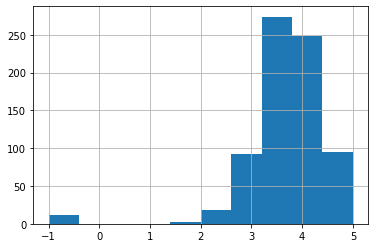

In [15]:
df.Rating.hist()

<AxesSubplot:>

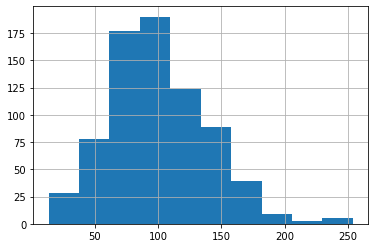

In [16]:
df.avg_salary.hist()

<AxesSubplot:>

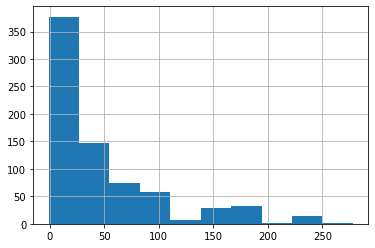

In [17]:
df.age.hist()

<AxesSubplot:>

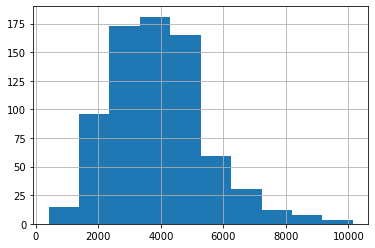

In [18]:
df.desc_len.hist()

<AxesSubplot:>

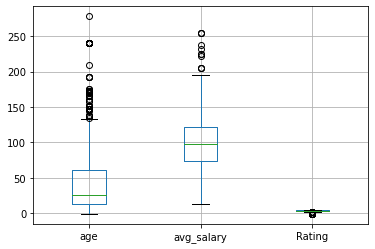

In [19]:
df.boxplot(column = ['age','avg_salary','Rating'])

<AxesSubplot:>

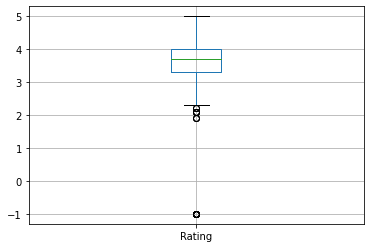

In [20]:
df.boxplot(column = 'Rating')

In [21]:
df[['age','avg_salary','Rating','desc_len']].corr()

,age,avg_salary,Rating,desc_len
age,1.000000,0.019492,0.024665,0.165628
avg_salary,0.019492,1.000000,0.013492,0.078093
Rating,0.024665,0.013492,1.000000,-0.012631
desc_len,0.165628,0.078093,-0.012631,1.000000


<AxesSubplot:>

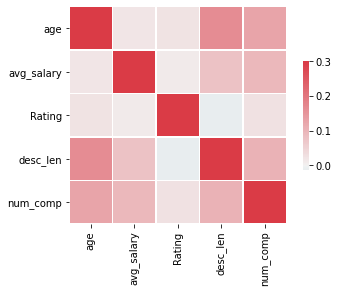

In [22]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[['age','avg_salary','Rating','desc_len','num_comp']].corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
df_cat = df[['Location', 'Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'company_txt', 'job_state', 'same_state', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'job_simp', 'seniority']]


graph for Location: total = 200


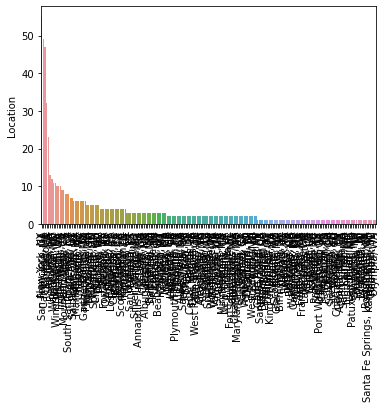

graph for Headquarters: total = 198


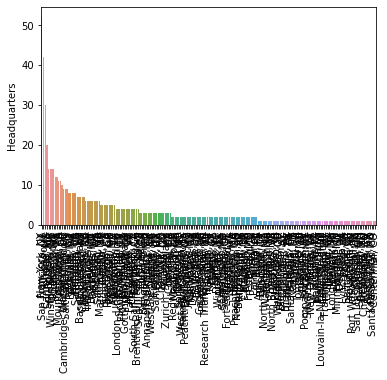

graph for Size: total = 9


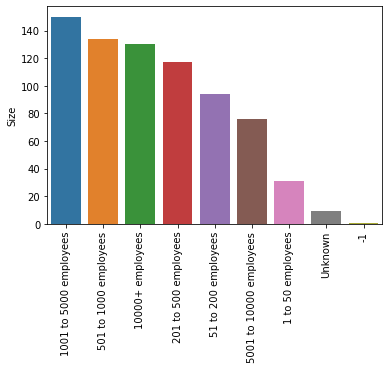

graph for Type of ownership: total = 11


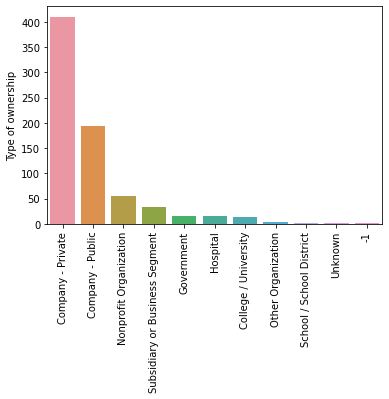

graph for Industry: total = 60


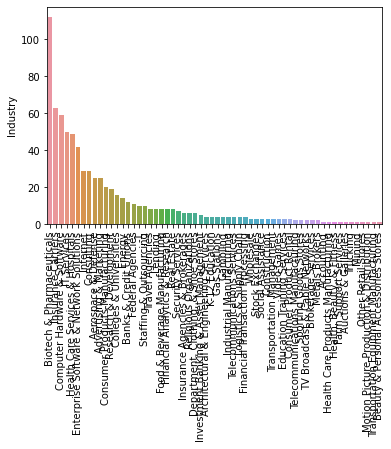

graph for Sector: total = 25


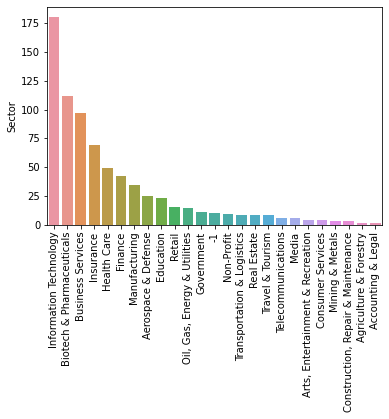

graph for Revenue: total = 14


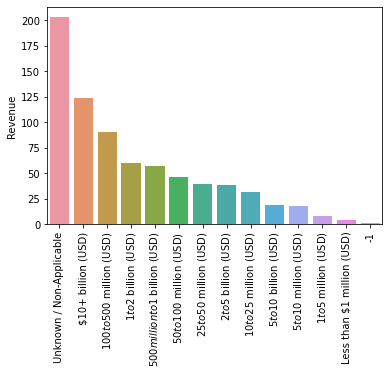

graph for company_txt: total = 343


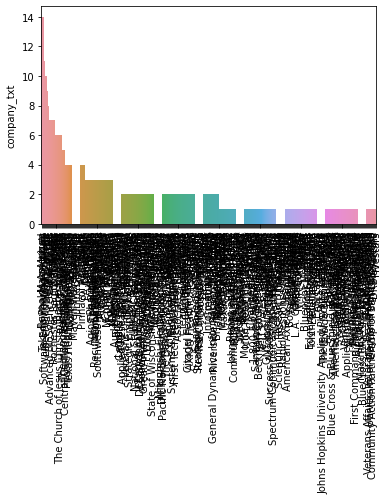

graph for job_state: total = 37


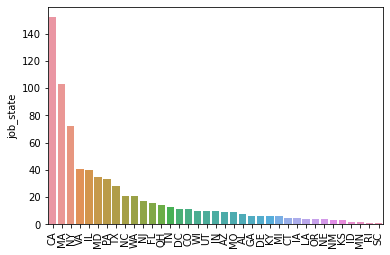

graph for same_state: total = 2


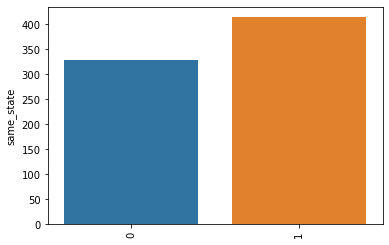

graph for python_yn: total = 2


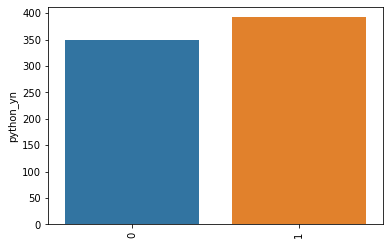

graph for R_yn: total = 2


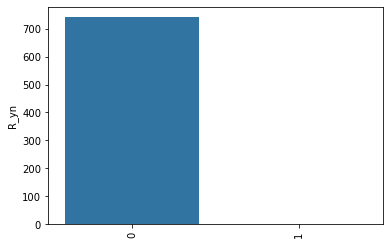

graph for spark: total = 2


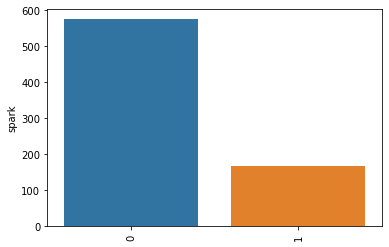

graph for aws: total = 2


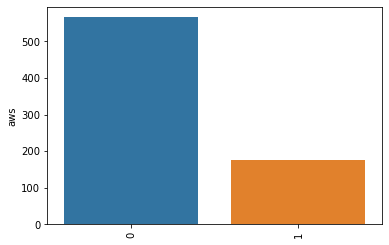

graph for excel: total = 2


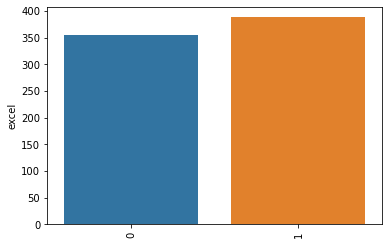

graph for job_simp: total = 7


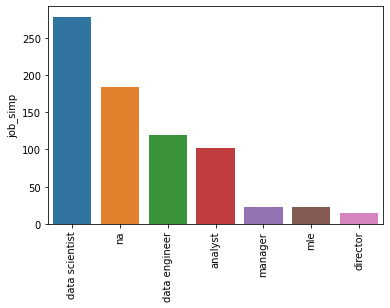

graph for seniority: total = 3


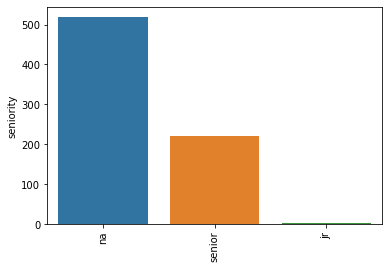

In [24]:
for i in df_cat.columns:
    cat_num = df_cat[i].value_counts()
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

graph for Location: total = 20


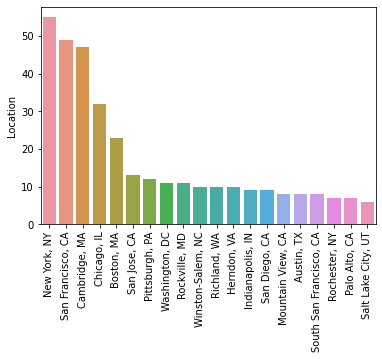

graph for Headquarters: total = 20


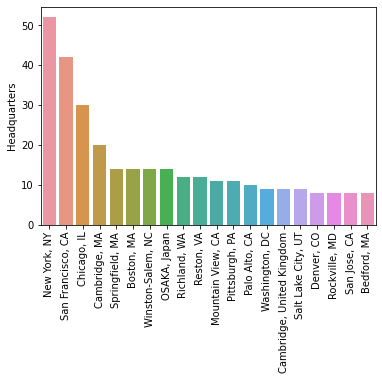

graph for company_txt: total = 20


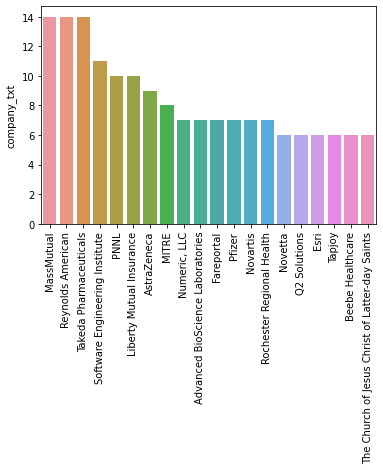

In [25]:
for i in df_cat[['Location','Headquarters','company_txt']].columns:
    cat_num = df_cat[i].value_counts()[:20]
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [26]:
pd.pivot_table(df, index = 'job_simp', values = 'avg_salary').sort_values(by='avg_salary', ascending=False)

,avg_salary
job_simp,
director,168.607143
mle,126.431818
data scientist,117.564516
data engineer,105.403361
na,84.853261
manager,84.022727
analyst,65.857843


In [27]:
pd.pivot_table(df, index=['job_simp', 'seniority'], values='avg_salary')

avg_salary
job_simp       seniority            
analyst        jr          53.250000
               na          61.308219
               senior      79.092593
data engineer  na          96.701220
               senior     124.689189
data scientist jr         106.500000
               na         107.043011
               senior     138.956522
director       na         168.607143
manager        na          84.022727
mle            na         119.133333
               senior     142.071429
na             na          73.988189
               senior     109.061404

In [28]:
pd.pivot_table(df, index = ['job_state','job_simp'], values = 'avg_salary').sort_values('job_state', ascending = False)

avg_salary
job_state job_simp                  
WI        na               54.000000
          data scientist  113.500000
          analyst          58.833333
WA        na               97.500000
          data scientist   99.764706
...                              ...
AZ        analyst          55.000000
          na              124.500000
AL        na               43.750000
          data engineer    65.000000
          analyst          62.200000

[114 rows x 1 columns]

In [29]:
pd.pivot_table(df, index=['job_state', 'job_simp'], values='avg_salary',
               aggfunc='count').sort_values('job_state', ascending=False)


avg_salary
job_state job_simp                  
WI        na                       4
          data scientist           3
          analyst                  3
WA        na                       1
          data scientist          17
...                              ...
AZ        analyst                  1
          na                       2
AL        na                       2
          data engineer            1
          analyst                  5

[114 rows x 1 columns]

In [30]:
pd.pivot_table(df[df.job_simp == 'data scientist'], index = 'job_state', values = 'avg_salary').sort_values('avg_salary', ascending = False)

,avg_salary
job_state,
DC,149.000000
CA,142.522059
UT,140.500000
MO,127.666667
IL,117.233333
NC,117.000000
NY,115.250000
MA,113.750000
WI,113.500000


In [31]:
df_pivots = df[['Rating', 'Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided',
                'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'Type of ownership', 'avg_salary']]

# 0 python not included
# 1 pytohn included
pd.pivot_table(df_pivots, index='Revenue', columns='python_yn',
               values='avg_salary', aggfunc='count')


python_yn,0,1
Revenue,,
$1 to $2 billion (USD),16.0,44.0
$1 to $5 million (USD),1.0,7.0
$10 to $25 million (USD),16.0,16.0
$10+ billion (USD),66.0,58.0
$100 to $500 million (USD),47.0,44.0
$2 to $5 billion (USD),17.0,22.0
$25 to $50 million (USD),24.0,16.0
$5 to $10 billion (USD),9.0,10.0
$5 to $10 million (USD),9.0,9.0


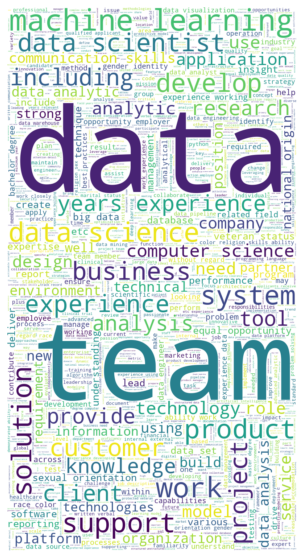

In [32]:
words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show() 

In [33]:
# df.to_csv('eda_data.csv')